# Algorithm Examples

In [1]:
using FreeBird
using Plots
using Statistics
using Distributions
using DataFrames
using CSV

# Global variables
kB = 8.617333262e-5  # eV/K

8.617333262e-5

In [2]:
# Define a square lattice
square_lattice_constant = 1.0
square_primitive_lattice_vectors = [square_lattice_constant 0.0 0.0; 0.0 square_lattice_constant 0.0; 0.0 0.0 1.0]
square_basis = [(0.0, 0.0, 0.0)]
square_supercell_dimensions = (4, 4, 1)
square_periodicity = (true, true, false)
square_adsorptions = [true for i in 1:square_supercell_dimensions[1]*square_supercell_dimensions[2]*length(square_basis)]
square_cutoff_radii = (1.1, 1.5)

# Define parameters for MCMC simulation
adsorption_energy = -0.04
nn_energy = -0.01
nnn_energy = -0.0025
temperatures = 200:-10:10
num_equilibration_steps = 10_000
num_sampling_steps = 10_000
random_seed = 1234

1234

In [3]:
# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Initialize a DataFrame to store the results
df_samples = DataFrame(N = Int[], T = Float64[], E = Float64[], Cv = Float64[], acceptance_rate = Float64[])

# Perform the Monte Carlo simulation
for N in [4]
    println("N = $N -------------------")

    # Initialize the lattice
    square_occupations = [false for i in 1:square_supercell_dimensions[1]*square_supercell_dimensions[2]*length(square_basis)]
    for i in sample(1:length(square_occupations), N, replace=false)  # Choose N from the available sites without replacement
        square_occupations[i] = true
    end
    initial_lattice = LatticeSystem(
        square_primitive_lattice_vectors,
        square_basis,
        square_supercell_dimensions,
        square_periodicity,
        square_occupations,
        square_adsorptions,
        square_cutoff_radii
    )

    for temp in temperatures
        println("T = $temp")

        # Equilibrate the lattice
        temperature = Float64(temp)
        equilibration_energies, equilibration_configurations, equilibration_accepted_steps = nvt_monte_carlo(
            initial_lattice,
            adsorption_energy,
            nn_energy,
            nnn_energy,
            temperature,
            num_equilibration_steps,
            random_seed
        )

        # Sample the lattice
        sampling_energies, sampling_configurations, sampling_accepted_steps = nvt_monte_carlo(
            equilibration_configurations[end],
            adsorption_energy,
            nn_energy,
            nnn_energy,
            temperature,
            num_sampling_steps,
            random_seed
        )

        # Compute the heat capacity
        E = mean(sampling_energies)
        Cv = var(sampling_energies) / (kB * temperature^2)

        # Compute the acceptance rate
        acceptance_rate = sampling_accepted_steps / num_sampling_steps

        # Append the results to the DataFrame
        append!(df_samples, DataFrame(N = N, T = temperature, E = E, Cv = Cv, acceptance_rate = acceptance_rate))

        # Update the initial lattice
        initial_lattice = deepcopy(sampling_configurations[end])
    end
end

# Save the results to a CSV file
L = square_supercell_dimensions[1]
M = square_supercell_dimensions[2]
parameters = "mc_square_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(square_cutoff_radii[1])_$(square_cutoff_radii[2])"
cv_file = "data/Cv_$parameters.csv"
CSV.write(cv_file, df_samples)

N = 4 -------------------
T = 200
T = 190
T = 180
T = 170
T = 160
T = 150
T = 140
T = 130
T = 120
T = 110
T = 100
T = 90
T = 80
T = 70
T = 60
T = 50
T = 40
T = 30
T = 20
T = 10


"data/Cv_mc_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv"

In [8]:
# Perform Wang-Landau simulation
num_steps = 10_000
flatness_criterion = 0.8
f_initial = Float64(MathConstants.e)
f_min = exp(10^-8)
energy_bins = 100
random_seed = 1234

# Choose an initial state
square_occupations = [false for i in 1:square_supercell_dimensions[1]*square_supercell_dimensions[2]*length(square_basis)]
for i in sample(1:length(square_occupations), 4, replace=false)  # Choose N from the available sites without replacement
    square_occupations[i] = true
end
initial_lattice = LatticeSystem(
    square_primitive_lattice_vectors,
    square_basis,
    square_supercell_dimensions,
    square_periodicity,
    square_occupations,
    square_adsorptions,
    square_cutoff_radii
)

# Perform the Wang-Landau simulation
density_of_states, histogram, bin_energies, energies, configurations = wang_landau(
    initial_lattice,
    adsorption_energy,
    nn_energy,
    nnn_energy,
    num_steps,
    flatness_criterion,
    f_initial,
    f_min,
    energy_bins,
    random_seed
)

f_min = 1.00000001


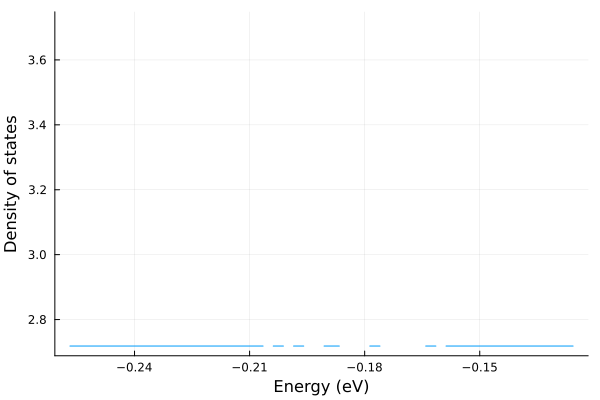

In [7]:
ρ = exp.(density_of_states)

# Plot the ρ
plot(bin_energies, ρ, xlabel="Energy (eV)", ylabel="Density of states", legend=false)

In [ ]:
# Normalize the density of states
normalized_density_of_states = density_of_states / sum(density_of_states)

# Compute the partition function as a function of temperature
relative_bin_energies = bin_energies .- minimum(bin_energies)
partition_function = zeros(length(temperatures))
for (i, temp) in enumerate(temperatures)
    beta = 1.0 / (kB * temp)
    partition_function[i] = sum(exp.(-beta .* relative_bin_energies) .* normalized_density_of_states)
end

# Plot the partition function as a function of temperature
# partition_function_plot = plot(temperatures, partition_function, xlabel="Temperature (K)", ylabel="Partition Function", legend=false, grid=true)

# Compute the internal energy as a function of temperature
println(relative_bin_energies)
internal_energy = zeros(length(temperatures))
for (i, temp) in enumerate(temperatures)
    beta = 1.0 / (kB * temp)
    internal_energy[i] = sum(relative_bin_energies .* exp.(-beta .* relative_bin_energies) .* normalized_density_of_states) / partition_function[i]
end
# internal_energy = internal_energy .+ minimum(bin_energies)

# Plot the internal energy as a function of temperature
internal_energy_plot = plot(temperatures, internal_energy .+ minimum(bin_energies), xlabel="Temperature (K)", ylabel="Internal Energy (eV)", legend=false, grid=true)
display(internal_energy_plot)

# Compute the heat capacity as a function of temperature
heat_capacity = zeros(length(temperatures))
for (i, temp) in enumerate(temperatures)
    beta = 1.0 / (kB * temp)
    heat_capacity[i] = sum((relative_bin_energies .- internal_energy[i]).^2 .* exp.(-beta .* relative_bin_energies) .* normalized_density_of_states) / (kB * temp^2 * partition_function[i])
end

# Convert the heat capacity to 1/kB units
heat_capacity = heat_capacity / kB

# # Plot the heat capacity as a function of temperature
# heat_capacity_plot_wl = plot(temperatures, heat_capacity, xlabel="Temperature (K)", ylabel="Heat Capacity (eV/K)", legend=false, grid=true)

In [ ]:
# Ensure the figures directory exists
if !isdir("figures")
    mkdir("figures")
end

# Read exact enumeration results
df_exact = CSV.read("data/Cv_exact_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.csv", DataFrame)

# Extract the data for N = 4
df_exact = filter(row -> row.N == 4, copy(df_exact))

# Create a heat capacity vs. temperature plot with MCMC and exact enumeration results
heat_capacity_plot = plot(df_samples.T, df_samples.Cv / kB, xlabel="Temperature (K)", ylabel="Heat Capacity (eV/K)", label="MCMC", grid=true)
plot!(heat_capacity_plot, df_exact.T, df_exact.Cv, label="Exact Enumeration")
plot!(heat_capacity_plot, temperatures, heat_capacity, label="Wang-Landau")

# Create a histogram of the acceptance rate as a function of temperature
acceptance_rate_plot = bar(df_samples.T, df_samples.acceptance_rate, xlabel="Temperature (K)", ylabel="Acceptance Rate", legend=false, grid=true)

# Combine the plots vertically
combined_plot = plot(acceptance_rate_plot, heat_capacity_plot, layout=(2, 1), link=:x)

# Save the combined plot to a file
savefig(combined_plot, "figures/Cv_mc_square_L4_M4_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.5.png")

# Display the combined plot
display(combined_plot)